<a id="top"></a>
#### QCT. Practices with Adiabatic Quantum Computing

# Airline Hub Optimization

#### Lecturers:
- Rafael Martín-Cuevas Redondo, rafamartinc@pm.me

***

In this notebook, we will explore how to optimize the operating costs of an airline, by selecting some of the airports used by the airline as hubs. These airports will act as a transfer point, connecting flights to get passengers to their final destination without having to establish a dedicated flight between each possible pair of airports. We will find the solution to this problem using the solvers provided by D-Wave Systems.

### Table of Contents

1. [Account configuration](#account_configuration)
2. [The Discrete Quadratic Model](#discrete_quadratic_model)

    - [Pre-processing](#dqm_preprocessing)
    - [Preparing a Discrete Quadratic Model](#dqm_preparation)
    - [Add the first constraint](#dqm_first_constraint)
    - [Add the second constraint](#dqm_second_constraint)
    - [Defining the objective function](#dqm_objective_function)
    - [Post-processing](#dqm_postprocessing)
    - [Execution and results](#dqm_execution)

***

Please run the following block to import the libraries that will be required during the execution of this notebook. If your system lacks any of the libraries mentioned, use ```pip install -r requirements.txt``` in a command line, within this notebook's folder, to ensure that all required libraries are installed.

In [1]:
import os
import itertools
import numpy

from dimod import DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler

import aux_functions
import importlib
importlib.reload(aux_functions)

print('Modules imported successfully!')

Modules imported successfully!


[Back to the top](#top)

***
<a id="account_configuration"></a>

## 1. Account configuration

In this section, we will log into our account at https://cloud.dwavesys.com/leap/ to retrieve our API Token and save it in a file named 'dwave_token.txt', located on the parent directory that contains the folder where this Jupyter notebook is located. We will then be able to retrieve the backends that are available to us.

In [2]:
with open(os.path.join('..', 'dwave_token.txt'), 'r') as file:
    os.environ['DWAVE_API_TOKEN'] = file.read()

[Back to the top](#top)

***
<a id="discrete_quadratic_model"></a>

## 2. The Discrete Quadratic Model

In this section, we will use D-Wave's DQM Solver to work on the problem described during the lecture: we want to interconnect $n$ airports so that any passenger can travel from any one airport to any other one, while minimizing the overall cost of the network. To do so, the passengers may have to change flights at [hubs](https://en.wikipedia.org/wiki/Airline_hub). Flights between hubs will benefit from a discount in the final cost, as larger aircrafts become profitable with the increase in the demand going through those connections, but there is a limit to the number of hubs that we can have.

You may find the full definition of this problem at [O'Kelly, Morton. (1987). A Quadratic Integer Program for the Location of Interacting Hub Facilities. European Journal of Operational Research. 32. 393-404. 10.1016/S0377-2217(87)80007-3](https://www.researchgate.net/publication/221990142_A_Quadratic_Integer_Program_for_the_Location_of_Interacting_Hub_Facilities).

[Back to the top](#top)

<a id="dqm_preprocessing"></a>
### 2.1. Pre-processing

We start our implementation by gathering all the data available to us: the passenger demand between each pair of airports, the cost per flow unit for all possible connections between airports (with these two values together, we could calculate the total cost of the network for every possible configuration), and the information about the airports themselves: their tag, and their location.

In [4]:
def load_demand(demand_file):

    demand = numpy.genfromtxt(demand_file, delimiter=',')
    demand = demand / numpy.sum(numpy.sum(demand))

    return demand

In [5]:
def load_costs(cost_file):
    
    cost = numpy.genfromtxt(cost_file, delimiter=',')
    num_airports = demand.shape[0]

    return cost

In [6]:
def load_airports(airports_file):
            
    airport_info = {}
    
    with open(airports_file, 'r') as file:
        for line in file.readlines(): 
            info = line.split(",")
            airport_name = info[1]
            airport_latitude = float(info[2])
            airport_longitude = float(info[3].strip())
            
            airport_info[airport_name] = [
                -airport_longitude, airport_latitude
            ]

    return airport_info

[Back to the top](#top)

<a id="dqm_preparation"></a>
### 2.2. Preparing a Discrete Quadratic Model

To fully specify our DQM, first we need to initialize the appropriate class and its variables. In the following sections, we will fully implement the methods described down below, that add each one of the parts that take place in the final model.

In [7]:
def build_dqm(demand, cost, max_hubs, hub_discount):
    
    num_airports = demand.shape[0]

    # Initialize DQM instance and its variables
    dqm = DiscreteQuadraticModel()
    for airport in range(num_airports):
        # Define each x_i for every airport 'i' in the available number of airports 'n'.
        # If x_i = j and i != j, then 'i' is not a hub.
        # If x_i = i, then 'i' is a hub.
        dqm.add_variable(num_cases=num_airports, label=airport)

    # Constraint 1: Every node that is not a hub must connect to a hub.
    add_first_constraint(dqm, num_airports, lagrange_multiplier=150)

    # Constraint 2: There must be exactly 'max_hubs' hubs.
    add_second_constraint(dqm, num_airports, max_hubs, lagrange_multiplier=250)
    
    # Set the objective function - minimizing the overall operating cost.
    add_objective_function(dqm, demand, cost, hub_discount)

    return dqm

[Back to the top](#top)

<a id="dqm_first_constraint"></a>
### 2.3. Adding the first constraint

The first constraint ensures that each node -that is not a hub- is connected to another node that is indeed a hub. Hubs will be recognized because their value indicates that they are connected to themselves.

In [8]:
def add_first_constraint(dqm, num_airports, lagrange_multiplier):
    
    for origin in range(num_airports):
        for destination in range(num_airports):
            if origin != destination:
                dqm.set_linear_case(
                    origin, destination,
                    dqm.get_linear_case(origin, destination) + lagrange_multiplier
                )
                dqm.set_quadratic_case(
                    origin, destination,
                    destination, destination,
                    dqm.get_quadratic_case(origin, destination, destination, destination) - lagrange_multiplier
                )

[Back to the top](#top)

<a id="dqm_second_constraint"></a>
### 2.4. Adding the second constraint

The second constraint ensures that there are at most 'max_hubs' hubs.

In [9]:
def add_second_constraint(dqm, num_airports, max_hubs, lagrange_multiplier):
    
    for origin in range(num_airports):
        dqm.set_linear_case(
            origin, origin,
            dqm.get_linear_case(origin, origin) + (1 - 2 * max_hubs) * lagrange_multiplier
        )
        
        for destination in range(num_airports):
            if origin != destination:
                dqm.set_quadratic_case(
                    origin, origin,
                    destination, destination,
                    dqm.get_quadratic_case(origin, origin, destination, destination) + lagrange_multiplier
                )

[Back to the top](#top)

<a id="dqm_objective_function"></a>
### 2.5. Defining the objective function

In this section, we will define the main objective function of the problem: the function that we want to minimize is the one that allows us to obtain the cost for every possible configuration of the network, depending on which airports we select and hubs, and how we connect all the remaining airports to them. If we find the configuration of the input variables that reaches the minimum possible value of the cost function -that is, while satisying the constraints that will be added later-, we will have found the optimal solution for our problem.

In [10]:
def add_objective_function(dqm, demand, cost, hub_discount):
    
    num_airports = demand.shape[0]

    for origin in range(num_airports):
        for destination in range(num_airports):
            for first_hub in range(num_airports):
                
                # Total cost of the flights going from the origin to its hub, calculated as
                # the total demand for that connection, times the cost of each unit of flow.
                dqm.set_linear_case(
                    origin, first_hub,
                    dqm.get_linear_case(origin, first_hub) \
                        + cost[origin][first_hub] * demand[origin][destination]
                )
                
                # Total cost of the flights going to a final destination from its hub,
                # calculated as the total demand for that connection, times the cost of each
                # unit of flow.
                dqm.set_linear_case(
                    destination, first_hub,
                    dqm.get_linear_case(destination, first_hub) \
                        + cost[destination][first_hub] * demand[origin][destination]
                )
                
                # Total cost of the flights between hubs, calculated as the total demand for
                # that connection, times the cost of each unit of flow for this part of the
                # journey, times one minus the discount applied to flights between hubs (to
                # get the final cost after the discount is applied).
                for second_hub in range(num_airports):
                    if origin != destination:
                        
                        dqm.set_quadratic_case(
                            origin, first_hub,
                            destination, second_hub,
                            dqm.get_quadratic_case(origin, first_hub, destination, second_hub) \
                                + (1 - hub_discount) * cost[first_hub][second_hub] * demand[origin][destination]
                        )
                        
                # Note that the demand is always related to the demand between the origin
                # and the destination of each traveler. The airports in between are only
                # considered to assess the costs.
                
                # About not mentioning any of the variables in the dqm.set...() methods:
                #    The methods 'dqm.set_linear_case' and 'dqm_set_quadratic_case' only
                #    require the bias associated to each variable or pair of variables.
                #    It is assumed that that bias is multiplying the variable itself. The
                #    initial value for each coefficient/bias is 0.
                
                # About using 'dqm.set_linear_case(..., dqm.get_linear_case(...) + ...)':
                #    We need to keep adding whatever value that linear case had, to avoid
                #    overwriting any previous coefficients.

[Back to the top](#top)

<a id="dqm_postprocessing"></a>
### 2.6. Post-processing

First, we will need a method to process the results provided by the solver, in order to translate them to the domain of our problem.

In [11]:
def interpret_results(sample, airport_names):

    hubs = []
    node_to_hub_connections = []
    
    for origin, destination in sample.items():
        if origin == destination:
            hubs.append(airport_names[origin])
        else:
            node_to_hub_connections.append((airport_names[origin], airport_names[destination]))

    return hubs, node_to_hub_connections

We also need a function to validate the solutions, to ensure that they are correct and satisfy the constraints.

In [12]:
def is_valid(hubs, node_to_hub_connections, max_hubs):
    
    result = True
    
    if len(hubs) != max_hubs:
        result = False
        
    i = 0
    while i < len(node_to_hub_connections) and result:
        origin, destination = node_to_hub_connections[i]
        
        if destination not in hubs:
            result = False
        i += 1
        
    return result

Finally, we will also need a function to know the cost associated to the chosen solution.

In [13]:
def get_cost(sample, demand, cost, hub_discount=0):

    sample_cost = 0
    num_airports = demand.shape[0]
    
    for origin in range(num_airports):
        for destination in range(origin + 1, num_airports):
            first_hub = sample[origin]
            second_hub = sample[destination]
            
            sample_cost += demand[origin][destination] * (
                cost[origin][first_hub]
                + cost[destination][second_hub]
                + (1 - hub_discount) * cost[first_hub][second_hub]
            )

    return sample_cost

[Back to the top](#top)

<a id="dqm_execution"></a>
### 2.7. Execution and results

We can now run the entire algorithm from end to end.

Input data processed. Building DQM...
DQM built. Solving...

Valid solution found!
   Hubs: ['ORD', 'LAX', 'PHL']
   Cost: 450.8494218922984


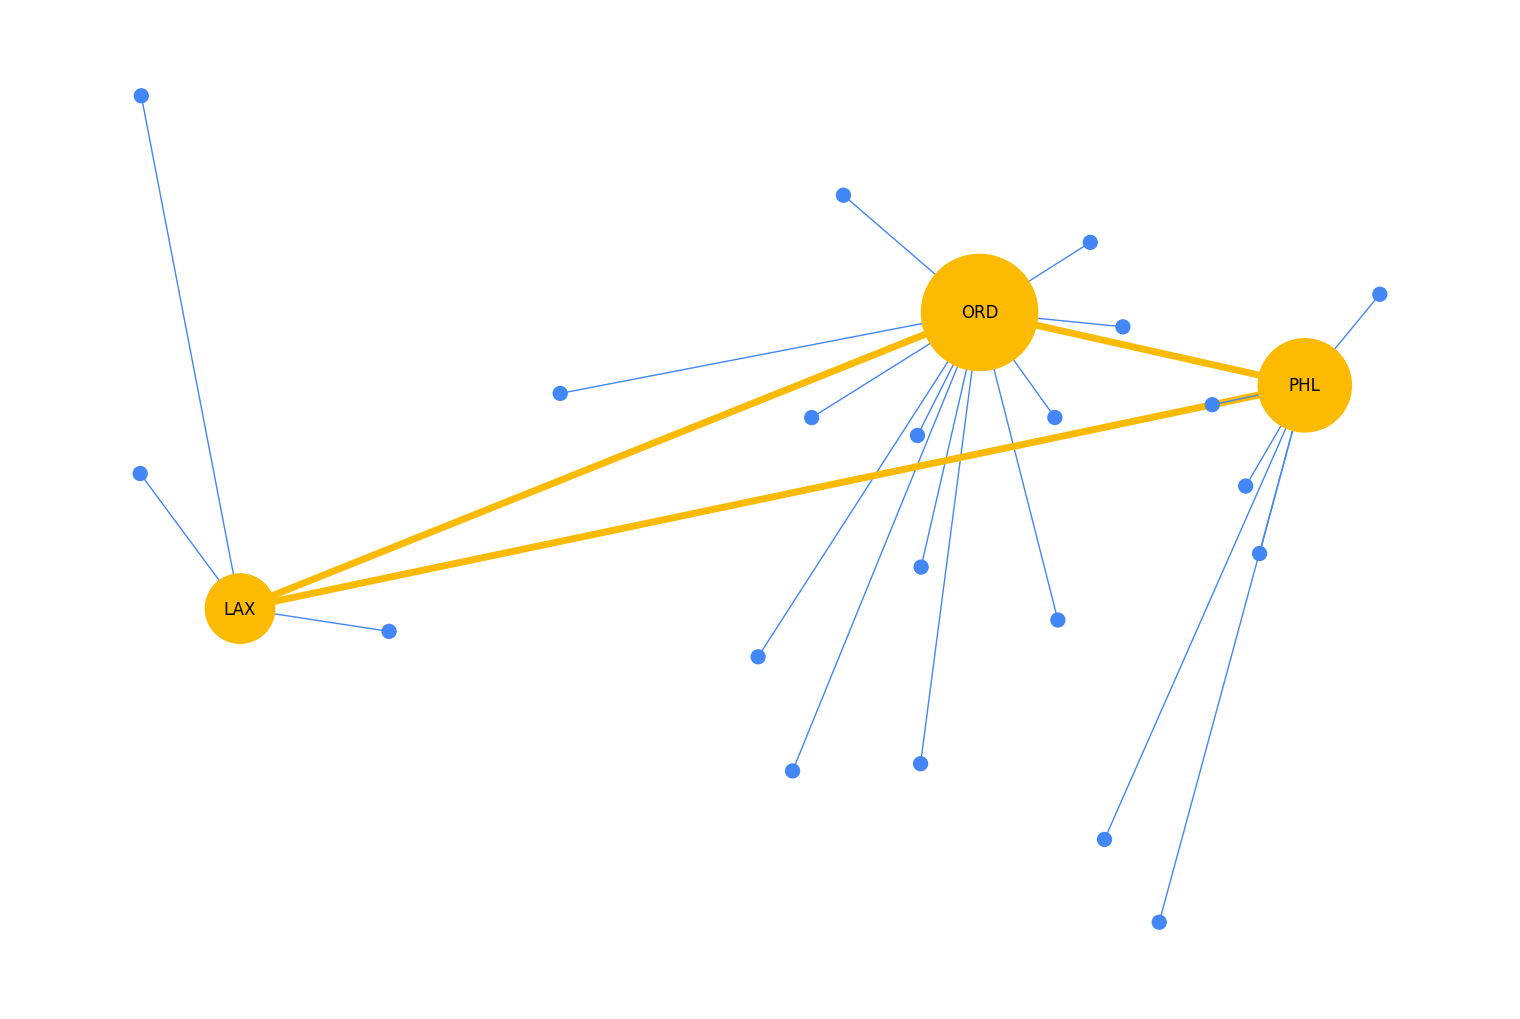

In [14]:
max_hubs = 3
hub_discount = 0.6  # Discount for flights between hubs. 0.6 means costs are reduced by 60%.

demand = load_demand('demand.csv')
cost = load_costs('cost.csv')
airport_info = load_airports('airports.txt')

airport_names = list(airport_info.keys())

print('Input data processed. Building DQM...')

dqm = build_dqm(demand, cost, max_hubs, hub_discount)

print('DQM built. Solving...')

#--------------------------------------------------------------
# To avoid using D-Wave's DQM Solver, assign one of the following examples retrieved from
# the solver to the variable 'best_sample', and comment the line down below that calls the
# solver and retrieves the results.
#--------------------------------------------------------------
sample_ord_sfo_bwi_466 = {0: 1, 1: 1, 2: 1, 3: 3, 4: 3, 5: 1, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 21, 12: 3, 13: 1, 14: 3, 15: 3, 16: 1, 17: 1, 18: 21, 19: 1, 20: 3, 21: 21, 22: 21, 23: 1, 24: 1}
sample_lax_cvg_bwi_469 = {0: 4, 1: 1, 2: 1, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 4, 11: 11, 12: 4, 13: 1, 14: 4, 15: 4, 16: 1, 17: 1, 18: 11, 19: 1, 20: 4, 21: 11, 22: 11, 23: 4, 24: 1}
sample_lax_atl_bwi_499 = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 11, 8: 1, 9: 0, 10: 0, 11: 11, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 1, 18: 11, 19: 1, 20: 0, 21: 11, 22: 11, 23: 0, 24: 1}

best_sample = sample_ord_sfo_bwi_466

# Comment the following line to disable the request to D-Wave's DQM Solver.
best_sample = LeapHybridDQMSampler().sample_dqm(dqm, label='Airline Hub Optimization').first.sample

hubs, node_to_hub_connections = interpret_results(best_sample, airport_names)

if not is_valid(hubs, node_to_hub_connections, max_hubs):
    print('\nValid solution not found.')
    
else:
    print('\nValid solution found!')
    print('   Hubs: {}'.format(hubs))
    print('   Cost: {}'.format(get_cost(best_sample, demand, cost, hub_discount)))

    hub_to_hub_connections = list(itertools.combinations(hubs, 2))
    aux_functions.draw_graph(
        nodes=airport_info,
        edges=hub_to_hub_connections + node_to_hub_connections,
        highlighted_nodes=hubs,
        highlighted_edges=hub_to_hub_connections
    )

[Back to the top](#top)